<a href="https://colab.research.google.com/github/Ankita-chouhan-github/Book-Recommendation-System/blob/main/Unsupervised_ML_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Unsupervised ML Capstone Project: Book Recommemdation System**

The objective of a book recommendation system is to predict buyer’s interest and recommend books to them respectively. That system can take into regard many parameters like book content and quality by filtering user reviews.

In [1]:
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
books = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Unsupervised ML Capstone Project/Books.csv',low_memory=False,error_bad_lines=False,encoding="latin-1")
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Unsupervised ML Capstone Project/Ratings.csv',low_memory=False,error_bad_lines=False,encoding="latin-1")
users = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Unsupervised ML Capstone Project/Users.csv',low_memory=False,error_bad_lines=False,encoding="latin-1")

print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)

Books Data:     (271360, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149780, 3)


#**Books Data**


---
**Data Description**

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.



In [ ]:
print("Columns: ", list(books.columns))
books.head()

Columns:  ['ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L']


,"ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L"
0,"0195153448,Classical Mythology,Mark P. O. Morf..."
1,"0002005018,Clara Callan,Richard Bruce Wright,2..."
2,"0060973129,Decision in Normandy,Carlo D'Este,1..."
3,"0374157065,Flu: The Story of the Great Influen..."
4,"0399135782,The Kitchen God's Wife,Amy Tan,1991..."


In [ ]:
print(books.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249936 entries, 0 to 249935
Data columns (total 1 columns):
 #   Column                                                                                         Non-Null Count   Dtype 
---  ------                                                                                         --------------   ----- 
 0   ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L  249936 non-null  object
dtypes: object(1)
memory usage: 1.9+ MB
None


In [ ]:
books.describe()

,"ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L"
count,249936
unique,249936
top,"0195153448,Classical Mythology,Mark P. O. Morf..."
freq,1


In [ ]:
# Missing value percentage
print(books.isnull().sum()/len(books)*100)

ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L    0.0
dtype: float64


In [ ]:
# Checking  for  null value in book author
books[books['Book-Author'].isna()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


In [3]:
#Filling the null value
books.loc[187689, 'Book-Author'] = 'Larissa Anne Downes'

In [ ]:
# Checking null values in publisher
books[books['Publisher'].isna()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...


In [4]:
#Replacing NaNs with correct  values
books.loc[128890, 'Publisher'] = 'Mundania Press LLC'
books.loc[129037, 'Publisher'] = 'Bantam'

In [ ]:
#insepcting the values in year of publication
books['Year-Of-Publication'].unique()

array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', '1955', '1946', '1936',
       '1930', '2011', '1925', '1948', '1943', '1947', '1945', '1923',
       '2020', '1939', '1926', '1938', '2030', '1911', '1904', '1949',
       '1932', '1928', '1929', '1927', '1931', '1914', '2050', '1934',
       '1910', '1933', '1902', '1924', '1921', '1900', '2038', '2026',
       '1944', '1917', '1901', '2010', '1908', '1906', '1935', '1806',
       '2021', '2012', '2006', 'DK Publishing Inc', 'Gallimard', '1909',
       

Name of few publication companies have been incorrectly put in this column.There are values such as 0 ,2024,2030 etc. which is also not possible .Let's rectify these mistakes

In [5]:
# correcting this error
books[books['Year-Of-Publication'] == 'DK Publishing Inc']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [6]:
# on searching for these  books we came to know about its authors
#ISBN '078946697X'
books.loc[books.ISBN == '078946697X','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '078946697X','Book-Author'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','Book-Title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

#ISBN '0789466953'
books.loc[books.ISBN == '0789466953','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '0789466953','Book-Author'] = "James Buckley"
books.loc[books.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','Book-Title'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"


In [7]:
#checking the rows having 'Gallimard' as yearOfPublication
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


In [8]:
books.loc[books.ISBN=='2070426769','Year-Of-Publication']=2003
books.loc[books.ISBN=='2070426769','Book-Author']='Jean-Marie Gustave Le ClÃ?Â©zio'
books.loc[books.ISBN=='2070426769','Publisher']='Gallimard'
books.loc[books.ISBN=='2070426769','Book-Title']="Peuple du ciel, suivi de 'Les Bergers"


In [9]:
#Checking if the corrections are in place
books.loc[books['ISBN'].isin(['2070426769','0789466953','078946697X'])]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [10]:
# changing dtype of year of publication
books['Year-Of-Publication'] =books['Year-Of-Publication'].astype(int)

In [11]:
# something is off about years of publication like:
books[(books['Year-Of-Publication'] > 0) & (books['Year-Of-Publication'] < 1800)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
227531,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...
253750,964442011X,Tasht-i khun,IsmaÃÂ°il Fasih,1376,Nashr-i Alburz,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...


In [12]:
#replacing with correct  values
books.loc[books.ISBN=='	9643112136','Year-Of-Publication'] = 2010
books.loc[books.ISBN=='964442011X', 'Year-Of-Publication'] = 1991

In [13]:
#Sustituting np.Nan in rows with year=0 or  greater than the current year,2022.
books.loc[(books['Year-Of-Publication'] > 2022) | (books['Year-Of-Publication'] == 0),'Year-Of-Publication'] = np.NAN

# replacing NaN values with median value of Year-Of-Publication
books['Year-Of-Publication'].fillna(int(books['Year-Of-Publication'].median()), inplace=True)

In [14]:
books['Book-Author'].value_counts()

Agatha Christie         632
William Shakespeare     567
Stephen King            524
Ann M. Martin           423
Carolyn Keene           373
                       ... 
R. Gelman                 1
Ellery R. Sheets          1
Artiste C. Arthur         1
Emily Pearl Kingsley      1
Christopher  Biffle       1
Name: Book-Author, Length: 102023, dtype: int64

In [15]:
books['Publisher'].value_counts()

Harlequin                        7535
Silhouette                       4220
Pocket                           3905
Ballantine Books                 3783
Bantam Books                     3646
                                 ... 
Windstream Publishing Company       1
Polaris Books                       1
Hannover House                      1
Amber Quill Press, LLC.             1
Connaught                           1
Name: Publisher, Length: 16804, dtype: int64

In [16]:
#Inspecting the missing values in 'Publisher' column
books.loc[books.Publisher.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


In [17]:
#Uppercasing the ISBN numbers
books['ISBN']=books['ISBN'].str.upper()

In [18]:
books[books['Book-Title']=='Emma']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1495,0451523067,Emma,Jane Austen,1994.0,New Amer Library Classics,http://images.amazon.com/images/P/0451523067.0...,http://images.amazon.com/images/P/0451523067.0...,http://images.amazon.com/images/P/0451523067.0...
8763,055321019X,Emma,Jane Austen,1981.0,Bantam Books,http://images.amazon.com/images/P/055321019X.0...,http://images.amazon.com/images/P/055321019X.0...,http://images.amazon.com/images/P/055321019X.0...
11571,0553212737,Emma,JANE AUSTEN,1984.0,Bantam,http://images.amazon.com/images/P/0553212737.0...,http://images.amazon.com/images/P/0553212737.0...,http://images.amazon.com/images/P/0553212737.0...
14263,0140258175,Emma,Jane Austen,1996.0,Penguin Putnam~trade,http://images.amazon.com/images/P/0140258175.0...,http://images.amazon.com/images/P/0140258175.0...,http://images.amazon.com/images/P/0140258175.0...
45955,B000051WXP,Emma,Jane Austen,1996.0,Random House,http://images.amazon.com/images/P/B000051WXP.0...,http://images.amazon.com/images/P/B000051WXP.0...,http://images.amazon.com/images/P/B000051WXP.0...
53513,0760701652,Emma,Jane Austen,1996.0,Barnes Noble Books,http://images.amazon.com/images/P/0760701652.0...,http://images.amazon.com/images/P/0760701652.0...,http://images.amazon.com/images/P/0760701652.0...
90473,2253140732,Emma,Jane Austen,1997.0,LGF,http://images.amazon.com/images/P/2253140732.0...,http://images.amazon.com/images/P/2253140732.0...,http://images.amazon.com/images/P/2253140732.0...
106616,0460010247,Emma,Jane Austen,1976.0,J m Dent &amp; Sons Ltd,http://images.amazon.com/images/P/0460010247.0...,http://images.amazon.com/images/P/0460010247.0...,http://images.amazon.com/images/P/0460010247.0...
133269,0553211595,Emma,Jane Austen,1984.0,Bantam,http://images.amazon.com/images/P/0553211595.0...,http://images.amazon.com/images/P/0553211595.0...,http://images.amazon.com/images/P/0553211595.0...
166404,0681218894,Emma,Jane Austen,1996.0,Hunter Publishing+inc,http://images.amazon.com/images/P/0681218894.0...,http://images.amazon.com/images/P/0681218894.0...,http://images.amazon.com/images/P/0681218894.0...


ISBN numbers for books with the same title and author would change if the year of release (revised editions),regional versions or publishing companies are different. So, let's look for rows where entire column values are identical.

In [19]:
#Checking for duplicates in books_df
books[books.duplicated()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
6635,002542730X,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...
11925,014062080X,The Scarlet Letter (Penguin Popular Classics),Nathaniel Hawthorne,1994.0,Penguin Books Ltd,http://images.amazon.com/images/P/014062080X.0...,http://images.amazon.com/images/P/014062080X.0...,http://images.amazon.com/images/P/014062080X.0...
16298,097089726X,Jasper,Michelle Groce,2003.0,Novello Festival Press,http://images.amazon.com/images/P/097089726X.0...,http://images.amazon.com/images/P/097089726X.0...,http://images.amazon.com/images/P/097089726X.0...
19266,039592720X,Interpreter of Maladies,Jhumpa Lahiri,1999.0,Houghton Mifflin Co,http://images.amazon.com/images/P/039592720X.0...,http://images.amazon.com/images/P/039592720X.0...,http://images.amazon.com/images/P/039592720X.0...
22339,042512164X,Capital Crimes,Lawrence Sanders,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/042512164X.0...,http://images.amazon.com/images/P/042512164X.0...,http://images.amazon.com/images/P/042512164X.0...
...,...,...,...,...,...,...,...,...
267020,088404632X,Dianetics: The Modern Science of Mental Health,L. Ron Hubbard,1995.0,Bridge Publications (CA),http://images.amazon.com/images/P/088404632X.0...,http://images.amazon.com/images/P/088404632X.0...,http://images.amazon.com/images/P/088404632X.0...
269297,055215038X,The Sleeper,Gillian White,2003.0,Corgi Books,http://images.amazon.com/images/P/055215038X.0...,http://images.amazon.com/images/P/055215038X.0...,http://images.amazon.com/images/P/055215038X.0...
269552,037376099X,Patient Nurse (Man Of The Month) (Harlequin D...,Diana Palmer,1997.0,Silhouette,http://images.amazon.com/images/P/037376099X.0...,http://images.amazon.com/images/P/037376099X.0...,http://images.amazon.com/images/P/037376099X.0...
270285,189481505X,I-O,Simon Logan,2002.0,Prime (OH),http://images.amazon.com/images/P/189481505X.0...,http://images.amazon.com/images/P/189481505X.0...,http://images.amazon.com/images/P/189481505X.0...


In [20]:
#Dropping the rows with the entire column values are duplicated
books.drop_duplicates(keep="first",inplace=True)
books.reset_index(drop=True,inplace=True)

In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271047 entries, 0 to 271046
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 271047 non-null  object 
 1   Book-Title           271047 non-null  object 
 2   Book-Author          271047 non-null  object 
 3   Year-Of-Publication  271047 non-null  float64
 4   Publisher            271047 non-null  object 
 5   Image-URL-S          271047 non-null  object 
 6   Image-URL-M          271047 non-null  object 
 7   Image-URL-L          271044 non-null  object 
dtypes: float64(1), object(7)
memory usage: 16.5+ MB


#**Users Data**


---
**Data Description**

Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.



In [21]:
#displaying the top 10 and bottom 10 rows of the dataframe
pd.concat([users.head(10),users.tail(10)],axis=0)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
5,6,"santa monica, california, usa",61.0
6,7,"washington, dc, usa",NaN
7,8,"timmins, ontario, canada",NaN
8,9,"germantown, tennessee, usa",NaN
9,10,"albacete, wisconsin, spain",26.0


In [ ]:
#inspecting the columns in users_df
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


* There are records of 278858 users in this dataframe.There are 3 columns in this dataframe.
* The 'Age' column has null values

In [22]:
#Checking for duplicates in users_df
users[users['User-ID'].duplicated()].sum()

User-ID     0.0
Location    0.0
Age         0.0
dtype: float64

In [23]:
#Percentage of missing values in users_df
print(users.isnull().sum()/len(users)*100)

User-ID      0.000000
Location     0.000000
Age         39.719857
dtype: float64


* The 39.7% of values in the 'Age' column are missing/NaN values

In [24]:
#summarizing data in 'Age' column
users['Age'].describe()

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64

The maximum value in the 'Age' column is 244. This is certainly an outlier.

<Axes: xlabel='Age'>

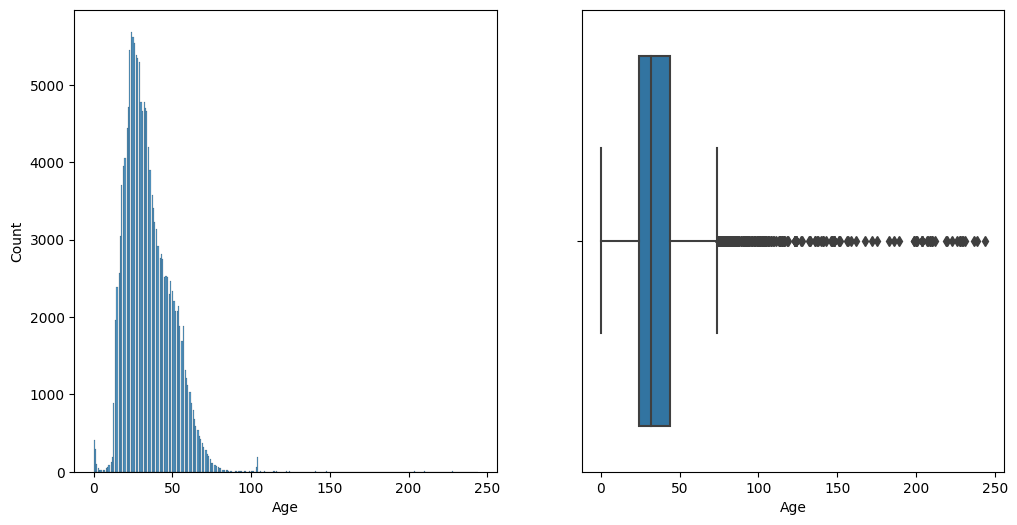

In [25]:
#Histogram showing distribution of ages
fig=plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.histplot(x='Age',data=users)

#boxplot of Age column
plt.subplot(1,2,2)
sns.boxplot(x='Age',data=users)

* Most of the users are from the age group 25-50
* It is highly unlikely to have users under the age of 4 and above 100.The peaks near 0 and 100 in the kdeplot indicates that there are some outlier values in the 'Age' column.

It is highly unlikely to have users of age above 95 and below 4 in this case.Let's replace these values with np.nan

In [26]:
#replacing the outliers in 'Age' with NaN value
users.loc[(users['Age']>95)|(users['Age']<4),'Age']=np.nan

In [27]:
#Displaying the current number of missing values in  'Age' column
print('The number of missing values is ',users['Age'].isnull().sum())
#Imputing such a large amount of null values will mean/mode/median will drastically change the distribution
users['Age'].describe()

The number of missing values is  112001


count    166857.000000
mean         34.734222
std          13.621521
min           4.000000
25%          24.000000
50%          32.000000
75%          44.000000
max          95.000000
Name: Age, dtype: float64

In [28]:
# create a normal distribution pd.Series to fill Nan values with
normal_age_series = pd.Series(np.random.normal(loc=users.Age.mean(),
                                               scale=users.Age.std(),
                                               size=users[users.Age.isna()]
                                                ['User-ID'].count()))

# take the absolute value of temp_age_series
abs_age_series=np.abs(normal_age_series)

# sort users df so as NaN values in age to be first and reset index to match with index of abs_age_series. Then using fillna()
users = users.sort_values('Age',na_position='first').reset_index(drop=True)
users.Age.fillna(round(abs_age_series), inplace = True)

In [29]:
users.Age.describe()

count    278858.000000
mean         34.741991
std          13.557728
min           0.000000
25%          25.000000
50%          33.000000
75%          44.000000
max          95.000000
Name: Age, dtype: float64

In [30]:
#percentage of missing values in 'Age' column
(users['Age'].isnull().sum()/len(users))*100

0.0

In [31]:
def age_group(age):
  '''
  defines the age group of users
  '''
  if age<13:
    x='Children'
  elif age>=13 and age<18:
    x='Teens'
  elif age>=18 and age<36:
    x='Youth'
  elif age>=36 and age<56:
    x='Middle aged adults'
  else:
    x='Elderly'
  return x

In [32]:
users['Age_group']=users['Age'].apply(lambda x: age_group(x))

The missing values in the 'Age' column have been imputed with values from a normal distribution.

Now let's inspect the 'Location' column.

In [33]:
#number of unique values in 'Location'
users['Location'].nunique()

57339

In [34]:
#extracting the country names from users_df
for i in users:
    users['Country']=users.Location.str.extract(r'\,+\s?(\w*\s?\w*)\"*$')

In [35]:
#Displaying the country names
set(users['Country'])

{'',
 '01776',
 '02458',
 '19104',
 '23232',
 '30064',
 '85021',
 '87510',
 '_ brasil',
 'a',
 'aaa',
 'adsgfdr',
 'afghanistan',
 'ahrensburg',
 'alachua',
 'albania',
 'alderney',
 'algeria',
 'allen',
 'ama lurra',
 'america',
 'american samoa',
 'andorra',
 'angola',
 'antarctica',
 'aotearoa',
 'argentina',
 'armenia',
 'aroostook',
 'aruba',
 'asturies',
 'auckland',
 'austbritania',
 'australia',
 'australii',
 'austria',
 'autralia',
 'az',
 'azerbaijan',
 'bademn wÃ¼rtemberg',
 'bahamas',
 'bahrain',
 'baltimore',
 'bangladesh',
 'barbados',
 'basilicata',
 'basque country',
 'bavaria',
 'baxter',
 'bbbzzzzz',
 'belarus',
 'belgi',
 'belgique',
 'belgium',
 'belize',
 'bell',
 'benin',
 'berguedÃ\xa0',
 'bermuda',
 'bernalillo',
 'bfe',
 'bhutan',
 'bih',
 'bkk',
 'bladen',
 'bolivia',
 'bosnia',
 'botswana',
 'brasil',
 'brazil',
 'brunei',
 'brunei darussalam',
 'bucks',
 'bulgaria',
 'buncombe',
 'burkina faso',
 'burkinafasu',
 'burlington',
 'burma',
 'butler',
 'c',
 'ca

In [36]:
#correcting the mispelled country names
users.loc[users['Country'].isin(['australii','autralia','western australia']), 'Country'] = 'australia'
users.loc[users['Country'].isin(['unite states','01776','02458','19104','23232','30064','85021','87510','united sates','united staes','united state','united statea','united stated','america'
                                      'united stated of america','united states','united states of america','us','us of a','us virgin islands',
                                      'usa  canada','usa currently living in england','uusa','usaa','wonderful usa','california','orange co']), 'Country'] = 'usa'
users.loc[users['Country'].isin(['united kindgdom', 'united kindgonm','united kingdom','u k']), 'Country'] = 'uk'
users.loc[users['Country'].isin(['the philippines', 'philippines', 'philippinies', 'phillipines', 'phils', 'phippines']), 'Country'] = 'philippines'
users.loc[users['Country'].isin(['','xxxxxx','universe','nowhere','x','y','a','öð¹ú','the','unknown',np.nan,'n/a','aaa','z','somewherein space']), 'Country'] = 'others'
users.loc[users['Country'].isin([ 'italia','italien','itlay']), 'Country'] = 'italy'
users.loc[users['Country'].isin([ ' china öð¹ú','chinaöð¹ú','chian']), 'Country'] = 'china'
users['Country'].replace([ 'the gambia','the netherlands','geermany','srilanka','saudia arabia','brasil','_ brasil','indiai','malaysian','hongkong','russian federation'],
                            ['gambia','netherlands','germany','sri lanka','saudi arabia','brazil','brazil','india','malaysia','hong kong','russia'],inplace=True)


In [37]:
#Converting the country names to uppercase
users['Country']=users['Country'].str.upper()

In [38]:
#Dropping the column 'Location'
users.drop('Location',axis=1,inplace=True)

In [39]:
users.columns

Index(['User-ID', 'Age', 'Age_group', 'Country'], dtype='object')

In [40]:
users.Country.value_counts()

USA               139746
CANADA             21658
UK                 18565
GERMANY            17074
SPAIN              13258
                   ...  
THAILOAND              1
ROSARIO                1
BURKINAFASU            1
ADSGFDR                1
SAN BERNARDINO         1
Name: Country, Length: 464, dtype: int64

#**Ratings Data**


---
**Data Description**

Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.


In [42]:
#displaying the first 5 rows
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [43]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [44]:
# checking null values
ratings.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [46]:
# checking for unique user ids and isbn values
print('Number of unique user ids is {} and ISBN no. is {}'.format(ratings['User-ID'].nunique(),
                                                                  ratings['ISBN'].nunique()))

Number of unique user ids is 105283 and ISBN no. is 340556


This means that many users are buying multiple books. Also some books are really famous and hence are bought by multiple users.

In [47]:
# making all the ISBN no. uppercase
ratings['ISBN'].apply(lambda x: x.upper())

0           034545104X
1           0155061224
2           0446520802
3           052165615X
4           0521795028
              ...     
1149775     1563526298
1149776     0679447156
1149777     0515107662
1149778     0590442449
1149779    05162443314
Name: ISBN, Length: 1149780, dtype: object

In [48]:
# checking for duplicates
ratings[ratings.duplicated()].sum()

User-ID        0.0
ISBN           0.0
Book-Rating    0.0
dtype: float64

In [49]:
# lets see if all the books in rating_df are also in books_df
ratings_new = ratings[ratings['ISBN'].isin(books['ISBN'])]

In [50]:
print('Shape of rating_df: {} and ratings_new: {}'.format(ratings.shape,
                                                            ratings_new.shape))

Shape of rating_df: (1149780, 3) and ratings_new: (1030617, 3)


In [51]:
# book ratings
ratings_new['Book-Rating'].value_counts().reset_index()

,index,Book-Rating
0,0,646974
1,8,91739
2,10,71194
3,7,66356
4,9,60754
5,5,45343
6,6,31673
7,4,7613
8,3,5117
9,2,2374


We can see for explicit ratings that rating 8 is received by most number of books followed by rating 10. There are 646974 implicitely rated books.

In [52]:
# most popular books
ratings_new.groupby('ISBN')['Book-Rating'].count().reset_index().sort_values(by='Book-Rating',
                                                                               ascending=False)[:10]

,ISBN,Book-Rating
215608,0971880107,2502
38505,0316666343,1295
70686,0385504209,883
7325,0060928336,732
32311,0312195516,723
87235,044023722X,647
21293,0142001740,615
144784,067976402X,614
132908,0671027360,586
93670,0446672211,585


But this contains both explicit and implicit rating, so we need to seperate them to get better idea.

In [53]:
explicit_rating = ratings_new[ratings_new['Book-Rating'] != 0]
implicit_rating = ratings_new[ratings_new['Book-Rating'] == 0]
print('Shape of explicit rating: {} and implicit rating: {}'.format(explicit_rating.shape, implicit_rating.shape))

Shape of explicit rating: (383643, 3) and implicit rating: (646974, 3)


In [54]:
# most purchased books including the implicitely rated books
ratings_new.groupby('ISBN')['User-ID'].count().reset_index().sort_values(by='User-ID',
                                                                           ascending=False)[:10]['ISBN'].values

array(['0971880107', '0316666343', '0385504209', '0060928336',
       '0312195516', '044023722X', '0142001740', '067976402X',
       '0671027360', '0446672211'], dtype=object)

In [55]:
# getting the book names corresponding to these ISBNs
isbn_nums = ['0971880107', '0316666343', '0385504209', '0060928336',
       '0312195516', '044023722X', '0142001740', '067976402X',
       '0671027360', '0446672211']
books[books['ISBN'].isin(isbn_nums)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
26,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
118,0671027360,Angels &amp; Demons,Dan Brown,2001.0,Pocket Star,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...
305,044023722X,A Painted House,John Grisham,2001.0,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.0...,http://images.amazon.com/images/P/044023722X.0...,http://images.amazon.com/images/P/044023722X.0...
356,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...
706,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998.0,Warner Books,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...
748,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
1105,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
1922,067976402X,Snow Falling on Cedars,David Guterson,1995.0,Vintage Books USA,http://images.amazon.com/images/P/067976402X.0...,http://images.amazon.com/images/P/067976402X.0...,http://images.amazon.com/images/P/067976402X.0...


In [56]:
# most popular explicitely rated books
explicit_rating.groupby('ISBN')['Book-Rating'].count().reset_index().sort_values(by='Book-Rating',
                                                                                 ascending=False)[:10]

,ISBN,Book-Rating
21915,0316666343,707
117593,0971880107,581
38771,0385504209,487
18032,0312195516,383
4122,0060928336,320
68795,059035342X,313
12303,0142001740,307
51715,0446672211,295
47910,044023722X,281
57539,0452282152,278


In [57]:
# getting the book names corresponding to these ISBNs
isbn_nums = ['0316666343', '0971880107', '0385504209', '0312195516', '0060928336']
books[books['ISBN'].isin(isbn_nums)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
26,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...
748,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
1105,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...


#**Merging Datasets**


---
Now we are going to merge the 3 dataset given to us to analyse them and work on them.



In [75]:
# for the rating dataset, we are only taking the explicit rating dataset
df = pd.merge(books, explicit_rating, on='ISBN', how='inner') #books and rating on ISBN
df = pd.merge(df, users, on='User-ID', how='inner') #above df with users on user-ID

In [76]:
#shape of the merged dataframe 'df'
df.shape

(383693, 13)

In [77]:
#displaying the top 3 rows of df
df.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Age,Age_group,Country
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,31.0,Youth,CANADA
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Scribner,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,8,5,31.0,Youth,CANADA
2,0887841740,The Middle Stories,Sheila Heti,2004.0,House of Anansi Press,http://images.amazon.com/images/P/0887841740.0...,http://images.amazon.com/images/P/0887841740.0...,http://images.amazon.com/images/P/0887841740.0...,8,5,31.0,Youth,CANADA


In [78]:
df.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'User-ID', 'Book-Rating',
       'Age', 'Age_group', 'Country'],
      dtype='object')

In [79]:
# Dropping unwanted columns from our dataframe 'df'
df.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace= True)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383693 entries, 0 to 383692
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 383693 non-null  object 
 1   Book-Title           383693 non-null  object 
 2   Book-Author          383693 non-null  object 
 3   Year-Of-Publication  383693 non-null  float64
 4   Publisher            383693 non-null  object 
 5   User-ID              383693 non-null  int64  
 6   Book-Rating          383693 non-null  int64  
 7   Age                  383693 non-null  float64
 8   Age_group            383693 non-null  object 
 9   Country              383693 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 32.2+ MB


#**Exploratory Data Analysis**

<Axes: title={'center': '\nMost popular ratings\n'}, xlabel='Book-Rating', ylabel='count'>

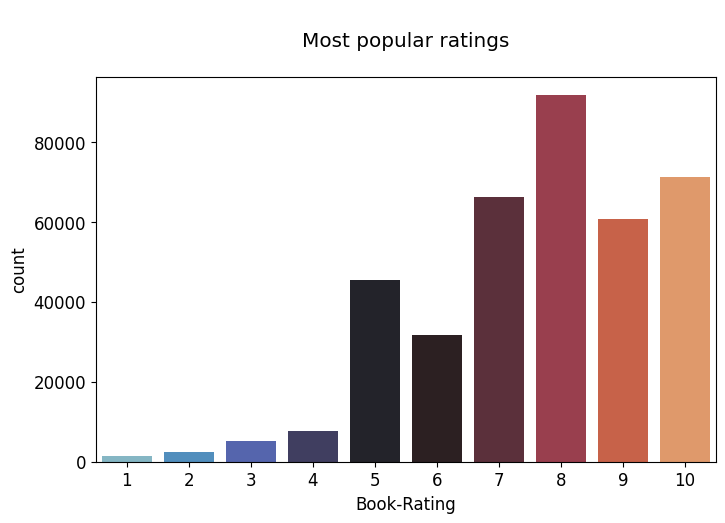

In [81]:
# most popular rating
plt.figure(figsize=[8,5])
plt.rc('font', size=12)
plt.title('\nMost popular ratings\n')
sns.countplot(data=df, x='Book-Rating', palette = 'icefire')

* Most of users have given above 4 ratings to books
* 8 is the most common rating given by users
* A considerable amount of books have gotten 10 rating.

<Axes: title={'center': '\nMost popular books\n'}, xlabel='Count', ylabel='Book-Title'>

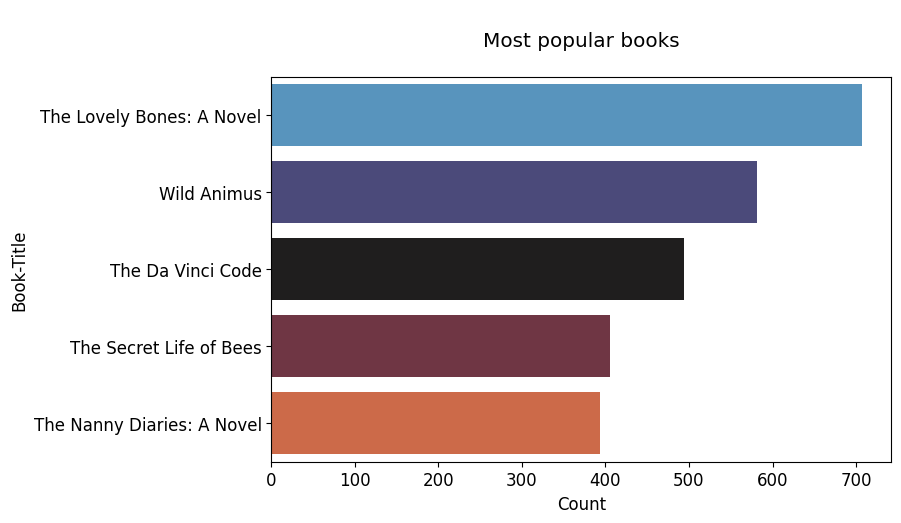

In [82]:
# top 5 most popular books

popular = df.groupby('Book-Title')['Book-Rating'].count().reset_index().sort_values(by='Book-Rating', ascending=False)[:5]
popular.columns = ['Book-Title', 'Count']

plt.figure(figsize=[8, 5])
plt.rc('font', size=12)
plt.title('\nMost popular books\n')
sns.barplot(data=popular, y='Book-Title', x='Count', palette = 'icefire')


* **"The lovely bones"** is the book which has been rated by most umber of users.

<Axes: title={'center': '\nMost popular Authors\n'}, xlabel='Book-Rating', ylabel='Book-Author'>

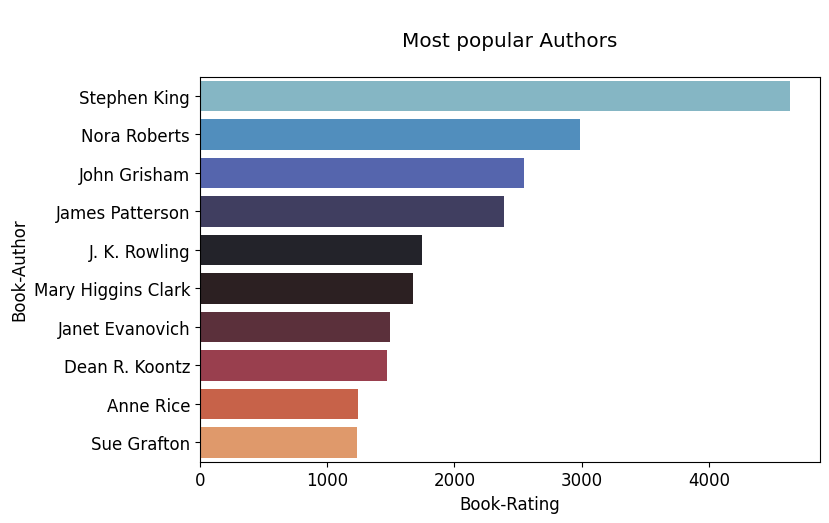

In [83]:
# most popular book authors
author = df.groupby('Book-Author')['Book-Rating'].count().reset_index().sort_values(by='Book-Rating', ascending=False)[:10]
plt.figure(figsize=[8, 5])
plt.rc('font', size=12)
plt.title('\nMost popular Authors\n')
sns.barplot(data=author, y='Book-Author', x='Book-Rating',palette='icefire')

* **Stephen King** is the most popular author with respect to number of ratings given to the books.

<Axes: xlabel='Age', ylabel='Density'>

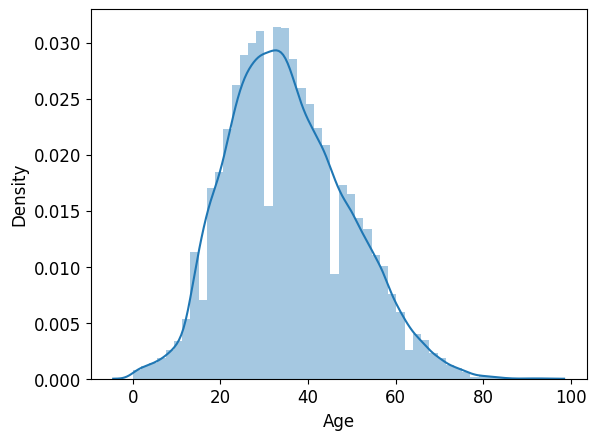

In [84]:
#Age distribution of users
age = users[users['User-ID'].isin(list(df['User-ID'].unique()))]
sns.distplot(age.Age)

* The majority of readers are between the ages of 20 and 40.
* Readers who are 80 to 100 years old make up a tiny minority.

Text(0.5, 0, 'No of users')

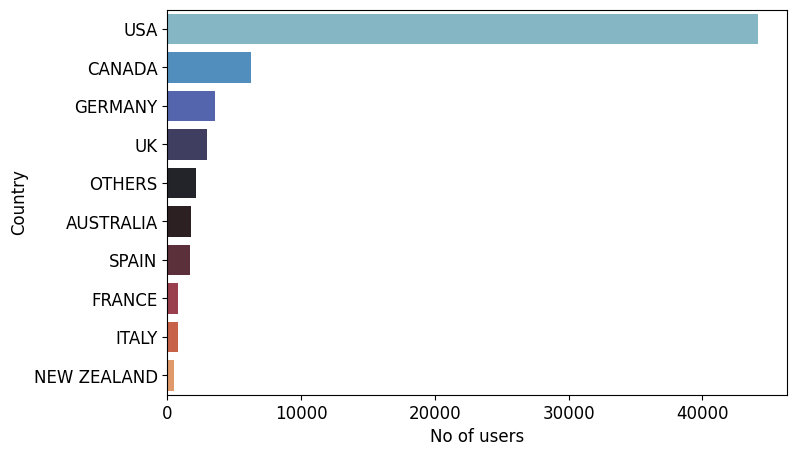

In [93]:
# countries with most readers
plt.figure(figsize=[8, 5])
countries = df.groupby('Country')['User-ID'].nunique().reset_index().sort_values(by='User-ID', ascending=False)[:10]
sns.barplot(data=countries, y='Country', x='User-ID',palette='icefire')
plt.xlabel('No of users')

* Most of the readers are from the United States followed by Canada and Germany.

In [94]:
#How many users have rated atleast 1 book?
df['User-ID'].value_counts()

11676     6940
98391     5692
189835    1899
153662    1846
23902     1180
          ... 
37259        1
53095        1
51124        1
235548       1
259679       1
Name: User-ID, Length: 68080, dtype: int64

There are 68080 users who have read and rated atleast 1 book.

In [95]:
df.groupby('User-ID')['Book-Rating'].count().describe()

count    68080.000000
mean         5.635914
std         41.736965
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       6940.000000
Name: Book-Rating, dtype: float64

<Axes: xlabel='Book-Title', ylabel='Publisher'>

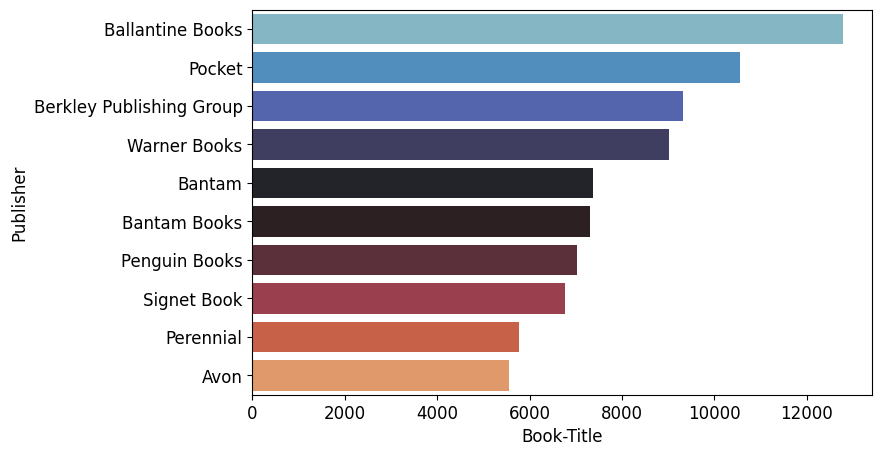

In [97]:
# Publisher with most books

publishers = df.groupby('Publisher')['Book-Title'].count().reset_index().sort_values(by='Book-Title', ascending=False)[:10]
plt.figure(figsize=[8, 5])
sns.barplot(data=publishers, x='Book-Title', y='Publisher',palette='icefire')


* Ballantine Books is most popular publisher based on the number of users who have rated their books.